### Load Data

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("potability").getOrCreate()

In [3]:
df_water = spark.read.csv("water_potability.csv",header = 'True', inferSchema = 'True')

In [4]:
type(df_water)

pyspark.sql.dataframe.DataFrame

In [5]:
df_water.printSchema()

root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)



In [6]:
df_water.select(['ph', 'Conductivity', 'Potability']).show(3)

+-----------------+-----------------+----------+
|               ph|     Conductivity|Potability|
+-----------------+-----------------+----------+
|             null|564.3086541722439|         0|
| 3.71608007538699|592.8853591348523|         0|
|8.099124189298397|418.6062130644815|         0|
+-----------------+-----------------+----------+
only showing top 3 rows



In [7]:
pd_water = df_water.toPandas()
pd_water.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [8]:
type(pd_water)

pandas.core.frame.DataFrame

<br>

### Visualize Data (also check outliers)

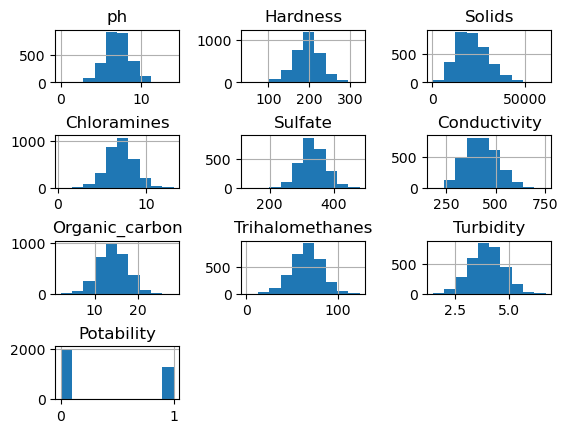

In [9]:
import matplotlib.pyplot as plt

pd_water.hist()
plt.subplots_adjust(wspace = 0.5, hspace = 1)
plt.show()

In [10]:
len(pd_water)

3276

In [11]:
pd_water.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

<br>

### Basic Data Transformation

In [79]:
from pyspark.ml.feature import Imputer

imputer = Imputer()

imputer.setInputCols(['ph', 'Sulfate', 'Trihalomethanes'])
imputer.setOutputCols(['Tr_{}'.format(c) for c in ['ph', 'Sulfate', 'Trihalomethanes']])
imputer.setStrategy('mean')
df_water = imputer.fit(df_water).transform(df_water)

In [80]:
#alternative to imputing
#df_water = df_water.dropna()

In [81]:
from pyspark.sql.functions import isnull, when, count, col

df_water.select([count(when(isnull(c), 1)).alias(c) for c in ['Tr_ph', 'Tr_Sulfate', 'Tr_Trihalomethanes']]).show()

+-----+----------+------------------+
|Tr_ph|Tr_Sulfate|Tr_Trihalomethanes|
+-----+----------+------------------+
|    0|         0|                 0|
+-----+----------+------------------+



In [82]:
df_ML = df_water.drop('ph', 'Sulfate', 'Trihalomethanes')
df_ML.printSchema()

root
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)
 |-- Tr_ph: double (nullable = true)
 |-- Tr_Sulfate: double (nullable = true)
 |-- Tr_Trihalomethanes: double (nullable = true)



In [83]:
mapping = dict(zip(df_ML.columns, ['H', 'SO', 'CH', 'CO', 'O', 'TU', 'label', 'P', 'SU', 'TR']))
df_ML = df_ML.select([col(c).alias(mapping[c]) for c in df_ML.columns])
df_ML = df_ML.select(['P', 'H','SO', 'CH', 'SU', 'CO', 'O', 'TR', 'TU', 'label'])
df_ML.printSchema()

root
 |-- P: double (nullable = true)
 |-- H: double (nullable = true)
 |-- SO: double (nullable = true)
 |-- CH: double (nullable = true)
 |-- SU: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- O: double (nullable = true)
 |-- TR: double (nullable = true)
 |-- TU: double (nullable = true)
 |-- label: integer (nullable = true)



<br>

### Preprocess Data

In [84]:
scaleColumns = df_ML.columns
scaleColumns.remove('label')
scaleColumns


['P', 'H', 'SO', 'CH', 'SU', 'CO', 'O', 'TR', 'TU']

In [85]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

assemblers = [VectorAssembler(inputCols=[col], outputCol="V_" + col) for col in scaleColumns]
scalers = [StandardScaler(inputCol="V_" + col, outputCol="T_" + col) for col in scaleColumns]
pipeline = Pipeline(stages=assemblers + scalers)
model = pipeline.fit(df_ML)
T_ML = model.transform(df_ML)

In [86]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
unlist = udf(lambda x: float(list(x)[0]), DoubleType())

for c in scaleColumns:
    T_ML = T_ML.withColumn(c, unlist(T_ML['T_'+c]))

In [87]:
T_ML = T_ML.drop(*[a+c for a in ["V_", "T_"] for c in scaleColumns])

T_ML.toPandas()

,P,H,SO,CH,SU,CO,O,TR,TU,label
0,4.817011,6.231507,2.371118,4.611384,10.196176,6.981939,3.137628,5.516273,3.797030,0
1,2.528021,3.936249,2.124640,4.191339,9.234966,7.335505,4.588655,3.571940,5.767245,0
2,5.509773,6.819887,2.270557,5.859372,9.234966,5.179227,5.099096,4.211832,3.915944,0
3,5.657833,6.519919,2.511061,5.090903,9.874387,4.494534,5.573042,6.362868,5.931413,0
4,6.185371,5.507993,2.050390,4.135344,8.580889,4.929359,3.493867,2.029057,5.221896,0
...,...,...,...,...,...,...,...,...,...,...
3271,3.175674,5.890606,5.426311,4.527009,9.959119,6.513211,4.200042,4.228801,5.684163,1
3272,5.312306,5.886698,1.976354,5.092186,9.234966,4.855603,6.016400,4.210323,3.585733,1
3273,6.408022,5.345618,3.781184,4.642981,9.234966,5.345497,3.336919,4.429038,4.227255,1
3274,3.487698,7.013547,1.366684,3.981692,9.234966,4.984693,3.376179,4.913684,6.033783,1


In [88]:
#Train/test split
import numpy as np

[X, L] = [np.array(T_ML.select(scaleColumns).collect()), np.array(T_ML.select('label').collect())]
[nData, nFeature] = np.shape(X)

#np.random.seed(42) # for fixed partition in each iter.
pidx = np.random.permutation(nData)

cut = int(nData*0.9)
trainX = X[pidx[:cut]] 
trainL = np.ravel(L[pidx[:cut]])

testX = X[pidx[cut+1:]]
testL = np.ravel(L[pidx[cut+1:]])

In [89]:
#Algorithm 1: Adaboost
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators = 70)
adaboost.fit(trainX,trainL)
pTrainL = adaboost.predict(trainX)
pTestL = adaboost.predict(testX)
print(sum(trainL == pTrainL)/np.size(trainL))
print(sum(testL == pTestL)/np.size(testL))

0.6638398914518318
0.5932721712538226


In [90]:
#Algorithm 2: SVM
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

SVM = SVC(kernel = 'rbf', gamma='auto')
SVM.fit(trainX, trainL)
pTrainL = SVM.predict(trainX)
pTestL = SVM.predict(testX)
print(sum(trainL == pTrainL)/np.size(trainL))
print(sum(testL == pTestL)/np.size(testL))

0.7316824966078698
0.6788990825688074


In [91]:
#Algorithm 3: Simple MLP classifier
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(hidden_layer_sizes = (60), solver = 'adam', max_iter = 2000)
NN.fit(trainX, trainL)
pTrainL = NN.predict(trainX)
pTestL = NN.predict(testX)
print(sum(trainL == pTrainL)/np.size(trainL))
print(sum(testL == pTestL)/np.size(testL))

0.6818181818181818
0.6483180428134556
